# DAT340 Assignment 5 - Spotting Cars

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use('seaborn')
%matplotlib inline

## Part 1: Training a convolutional neural network

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale color values
data_gen = ImageDataGenerator(rescale=1.0/255)

imgdir = 'a5_images' 
img_size = 64
batch_size = 32

# read and transform training set 
train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

# read and transform validation set 
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [3]:
# load one batch from training set generator 
Xbatch, Ybatch = train_generator.next()
Xbatch.shape

(32, 64, 64, 3)

Label: 1.0 (class = other)


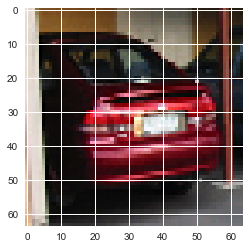

In [4]:
# test of training set 
plt.imshow(Xbatch[1])
print(f'Label: {Ybatch[1]} (class = other)')

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers


input_shape = (img_size, img_size, 3)

# returns a CNN
def make_convnet():

    # sequential model with multiple layers 
    model = Sequential()

    # convolutional and maxpooling layers 
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # feedforward and output layers with dropout and L2 regularization
    model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    return model

In [12]:
from keras.callbacks import EarlyStopping

# create CNN 
model = make_convnet()

# create CNN using log loss, Adam optimizer 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# callback for early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

# fit and validate model 
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=2, callbacks=[early_stop])

# evaluate model
score = model.evaluate(validation_generator, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
50/50 - 6s - loss: 1.3197 - accuracy: 0.5263 - val_loss: 0.7867 - val_accuracy: 0.5781
Epoch 2/50
50/50 - 5s - loss: 0.7253 - accuracy: 0.6087 - val_loss: 0.6783 - val_accuracy: 0.6649
Epoch 3/50
50/50 - 5s - loss: 0.6494 - accuracy: 0.6694 - val_loss: 0.6401 - val_accuracy: 0.7101
Epoch 4/50
50/50 - 5s - loss: 0.6235 - accuracy: 0.7163 - val_loss: 0.6109 - val_accuracy: 0.7222
Epoch 5/50
50/50 - 5s - loss: 0.5517 - accuracy: 0.7669 - val_loss: 0.5609 - val_accuracy: 0.7569
Epoch 6/50
50/50 - 7s - loss: 0.5380 - accuracy: 0.7650 - val_loss: 0.5710 - val_accuracy: 0.7569
Epoch 7/50
50/50 - 6s - loss: 0.5096 - accuracy: 0.7856 - val_loss: 0.5496 - val_accuracy: 0.7743
Epoch 8/50
50/50 - 5s - loss: 0.5106 - accuracy: 0.7856 - val_loss: 0.5486 - val_accuracy: 0.7656
Epoch 9/50
50/50 - 5s - loss: 0.5021 - accuracy: 0.7850 - val_loss: 0.5930 - val_accuracy: 0.7396
Epoch 10/50
50/50 - 5s - loss: 0.4745 - accuracy: 0.8094 - val_loss: 0.5370 - val_accuracy: 0.7847
Epoch 11/50
50/50 -

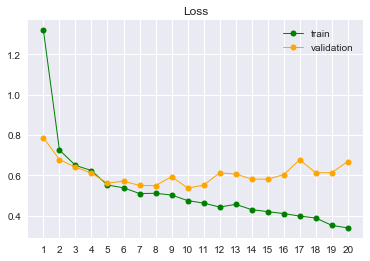

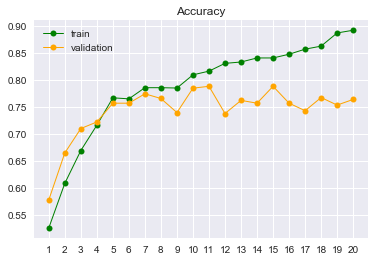

In [13]:
# save history as dataframe 
hist_df = pd.DataFrame(history.history)

# extract data  
train_loss = hist_df['loss']
val_loss = hist_df['val_loss']
train_acc = hist_df['accuracy']
val_acc = hist_df['val_accuracy']

x_range = hist_df.index + 1

# plot training and validation loss
plt.plot(x_range, 'loss', data=hist_df, marker='o', markerfacecolor='green', markersize=6, color='green', linewidth=1, label='train')
plt.plot(x_range, 'val_loss', data=hist_df, marker='o', markerfacecolor='orange', markersize=6, color='orange', linewidth=1, label='validation')
plt.xticks(x_range)
plt.title('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.plot(x_range, 'accuracy', data=hist_df, marker='o', markerfacecolor='green', markersize=6, color='green', linewidth=1, label='train')
plt.plot(x_range, 'val_accuracy', data=hist_df, marker='o', markerfacecolor='orange', markersize=6, color='orange', linewidth=1, label='validation')
plt.xticks(x_range)
plt.title('Accuracy')
plt.legend()
plt.show()

### Notes on Part 1: Training a convolutional neural network
Our function 'make_convnet' returnas a sequential model, which alternates two-dimensional convolutional layers with two-dimensional MaxPooling layers, two common practices regarding building blocks of convolutional neural networks. These layers are then flattenned, before regular so called feedforward layers are put on top of the model. Convolutional layers used ReLu as activation function, and our output layer used binary cross entropy (i.e., log-loss) since it is a binary classification problem. The Adam optimizer was used, utilizing adaptive gradient descent in order to reach high performance faster. 

As mentioned in the given task, accuracy was quite volatile due to the small amount of training data. Still, overfitting proved to be an issue if no measures where taken. Therefore, early stopping was used and intervened after 20 epochs. Since the patience of our early stopping was 10 epochs, we trained the model for 50 epochs to make sure the model was given the possibility to reach an acceptable level. Further, we added a dropout layer between our two dense layers, together with a minor L2 regularization on the first of them. Accuracy varied, but was deemed to be okay. Early stopping proved a little problematic due to varying accuracy, requiring multiple runs to really observe the model. 

As the plots above illustrate, the model continued to perform better and better on the training set, validating the use of preventive measures against overfitting although validation performance wasn't great. One possibly could have tuned this model to better performance, although this would've required both more time and computational power.

## Part 2: Data augmentation

In [11]:
# augmenting data 
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1.0/255)

# read and transform training set with data augmentation
train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [12]:
# create CNN 
model = make_convnet()

# create CNN using log loss, Adam optimizer 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# fit and validate model 
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=2, callbacks=[early_stop])

# evaluate model
score = model.evaluate(validation_generator, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
50/50 - 6s - loss: 1.2125 - accuracy: 0.5938 - val_loss: 0.7466 - val_accuracy: 0.6233
Epoch 2/50
50/50 - 7s - loss: 0.6666 - accuracy: 0.6706 - val_loss: 0.6652 - val_accuracy: 0.6615
Epoch 3/50
50/50 - 7s - loss: 0.6148 - accuracy: 0.7056 - val_loss: 0.6897 - val_accuracy: 0.6997
Epoch 4/50
50/50 - 7s - loss: 0.6283 - accuracy: 0.7000 - val_loss: 0.6140 - val_accuracy: 0.7240
Epoch 5/50
50/50 - 7s - loss: 0.6283 - accuracy: 0.6969 - val_loss: 0.7044 - val_accuracy: 0.6545
Epoch 6/50
50/50 - 7s - loss: 0.6146 - accuracy: 0.7144 - val_loss: 0.5882 - val_accuracy: 0.7413
Epoch 7/50
50/50 - 7s - loss: 0.5846 - accuracy: 0.7387 - val_loss: 0.6140 - val_accuracy: 0.7274
Epoch 8/50
50/50 - 7s - loss: 0.5724 - accuracy: 0.7362 - val_loss: 0.5886 - val_accuracy: 0.7587
Epoch 9/50
50/50 - 7s - loss: 0.5728 - accuracy: 0.7506 - val_loss: 0.5725 - val_accuracy: 0.7431
Epoch 10/50
50/50 - 6s - loss: 0.5770 - accuracy: 0.7425 - val_loss: 0.5822 - val_accuracy: 0.7569
Epoch 11/50
50/50 -

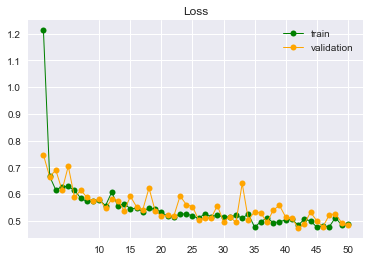

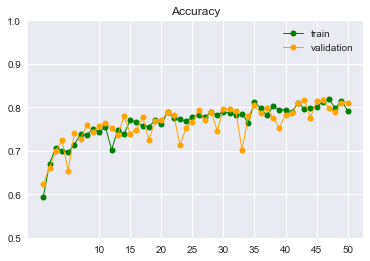

In [22]:
# save history as dataframe 
hist_df = pd.DataFrame(history.history)

# extract data  
train_loss = hist_df['loss']
val_loss = hist_df['val_loss']
train_acc = hist_df['accuracy']
val_acc = hist_df['val_accuracy']

x_range = hist_df.index + 1

# plot training and validation loss
plt.plot(x_range, 'loss', data=hist_df, marker='o', markerfacecolor='green', markersize=6, color='green', linewidth=1, label='train')
plt.plot(x_range, 'val_loss', data=hist_df, marker='o', markerfacecolor='orange', markersize=6, color='orange', linewidth=1, label='validation')
plt.xticks([10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.title('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.plot(x_range, 'accuracy', data=hist_df, marker='o', markerfacecolor='green', markersize=6, color='green', linewidth=1, label='train')
plt.plot(x_range, 'val_accuracy', data=hist_df, marker='o', markerfacecolor='orange', markersize=6, color='orange', linewidth=1, label='validation')
plt.xticks([10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.ylim(0.5,1)
plt.title('Accuracy')
plt.legend()
plt.show()

### Notes on Part 2: Data augmentation
In part 2, we augmented the data (images) using the ImageDataGenerator. We decided to use rotation_range, which specifies the degree of random rotations. Further, both width_shift_range and height_shift_range were also used, which shifts the images vertically and horizontally. Finally, horizontal_flip was set to True, randomly flipping inputs horizontally. These augmentation alters the locations of edges and abstract patterns which our CNN tries to learn, making the model more robust. 

Similarly to before the data augmentation, accuracy proved rather volatile. Although the model performs better when trained on augmented data, the difference is not too significant. Still, the model adapts to the training data in a much slower pace than previously, suggesting that the model may be limited by our build of it rather than the training data itself. The early stopping isn't enabled either, suggesting that we're seeing an increasing validation accuracy over all 50 epochs (this varies from run to run, but runs for most of the 50 epochs in most cases). Limitations regarding computaional power prevents us from exploring this thoroughly. 

## Interlude: Applying a pre-trained convolutional neural network

In [25]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

# create full VGG16 model 
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

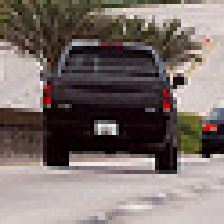

[[('n03417042', 'garbage_truck', 0.15934157),
  ('n03345487', 'fire_engine', 0.11155716),
  ('n04252225', 'snowplow', 0.100917086),
  ('n06874185', 'traffic_light', 0.08726411),
  ('n03977966', 'police_van', 0.08684494)]]

In [26]:
# load image picturing a car 
img = load_img(imgdir + '/train/car/0000.jpg', target_size=(224,224))
display(img)

# preprocess and reshape image 
img = img_to_array(img)
img = preprocess_input(img)
img = img.reshape(1, 224, 224, 3)

# prediction
pred = vggmodel.predict(img)
decode_predictions(pred)

### Notes on Interlude: Applying a pre-trained convolutional network
As one can see, the picture most likely is of a pickup. The predictions made aren't all too accurate, with garbage truck and fire engine as the top two guesses (neither with outstanding probability). Still, these predications illustrate that the model has some sense of what's going on since police van is in the top five, which isn't too different from the actual image content. 

## Part 3: Using VGG-16 as feature extractor 

In [27]:
# create feature extractor from VGG16's convolutional parts
feature_extractor = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input) 


def create_vgg16_features(ctgry):

    # create generator 
    generator = vgg_data_gen.flow_from_directory(
        imgdir + f'/{ctgry}',
        target_size=(img_size, img_size),
            batch_size=32,
            class_mode='binary',
            classes=['other', 'car'],
            seed=12345,
            shuffle=False
    )


    # make predictions using VGG16 feature extractor 
    cnn_features = feature_extractor.predict(generator, verbose=2)

    # save predictions
    with open(f'{ctgry}_cnn_features' , 'wb') as f:
        np.save(f, cnn_features)

In [28]:
# create VGG16 features for training data 
create_vgg16_features('train')

# create VGG16 features for validation data
create_vgg16_features('validation')

Found 1600 images belonging to 2 classes.
50/50 - 16s
Found 576 images belonging to 2 classes.
18/18 - 6s


In [29]:
# helper function to get labels
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

In [57]:
def train_on_cnnfeatures(train_features, val_features):

    # load training features
    with open(train_features, 'rb') as f:
        X_train = np.load(f)

    # load validation features
    with open(val_features, 'rb') as f:
        X_test = np.load(f)

    # create model
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(units=1, activation='sigmoid'))

    # compile using log loss and Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # get labels for training and validation data
    y_train = get_labels(X_train.shape[0])
    y_test = get_labels(X_test.shape[0])

    # train model 
    history = model.fit(X_train, y_train, epochs=20, verbose=2)

    # evaluate model
    score = model.evaluate(X_test, y_test, verbose=2)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [59]:
train_on_cnnfeatures('train_cnn_features', 'validation_cnn_features')

Epoch 1/20
50/50 - 0s - loss: 27.8223 - accuracy: 0.7887
Epoch 2/20
50/50 - 0s - loss: 18.1170 - accuracy: 0.8756
Epoch 3/20
50/50 - 0s - loss: 12.4841 - accuracy: 0.9081
Epoch 4/20
50/50 - 0s - loss: 8.7703 - accuracy: 0.9269
Epoch 5/20
50/50 - 0s - loss: 6.2950 - accuracy: 0.9419
Epoch 6/20
50/50 - 0s - loss: 4.5668 - accuracy: 0.9481
Epoch 7/20
50/50 - 0s - loss: 3.4151 - accuracy: 0.9425
Epoch 8/20
50/50 - 0s - loss: 2.5897 - accuracy: 0.9544
Epoch 9/20
50/50 - 0s - loss: 1.9438 - accuracy: 0.9650
Epoch 10/20
50/50 - 0s - loss: 1.4875 - accuracy: 0.9694
Epoch 11/20
50/50 - 0s - loss: 1.1757 - accuracy: 0.9606
Epoch 12/20
50/50 - 0s - loss: 0.9727 - accuracy: 0.9638
Epoch 13/20
50/50 - 0s - loss: 0.7972 - accuracy: 0.9694
Epoch 14/20
50/50 - 0s - loss: 0.6948 - accuracy: 0.9606
Epoch 15/20
50/50 - 0s - loss: 0.6199 - accuracy: 0.9594
Epoch 16/20
50/50 - 0s - loss: 0.5031 - accuracy: 0.9694
Epoch 17/20
50/50 - 0s - loss: 0.4745 - accuracy: 0.9681
Epoch 18/20
50/50 - 0s - loss: 0.4701

### Notes on Part 3: Using VGG-16 as feature extractor
Accurcy rose significantly when using VGG-16 as feature extractor, mostly exceeding 90%. Due to the convolutional part of the model being pre-trained, we're given more freedom regarding feedforward layers here not limited by computational power. Therefore, we added one dense layer. The model seemed to overfit with training data reaching perfect (1.00) without preventive measures, thus dropout layers where added inbetween our dense layers with a dropout factor of 0.3 which is rather high but appeared necessary. Additionally, L2 regularization was once again used on the dense layers but with a higher regularization factor (0.1). This limited training accuracy to about 95-96% and resulted in a test accuracy of approximately 91%. 

## Part 4: Visualizing the learned features

In [60]:
# utility function for visualizing weights 
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

In [256]:
# get overview of convolutional layers
for layer in vggmodel.layers:
    if 'conv' in layer.name:
        filters, biases = layer.get_weights()
        print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [238]:
def visualize_patterns(patterns):

    # for each pair of patterns (pos/neg)
    for pattern in patterns:
        for j in range(3):

            ax = plt.subplot(1, 3, j+1)
            ax.set_xticks([])
            ax.set_yticks([])

            # plot pattern in grayscale
            plt.imshow(pattern[:, :, j], cmap='gray')
            
        plt.show()

In [239]:
# get weights of convolutional layers
first_layer_weights = vggmodel.get_weights()[0]

Layer: Block1_Conv1 /n Filter: 1 
 First row shows positive pattern, second negative.


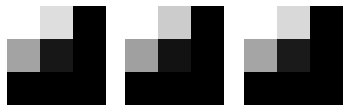

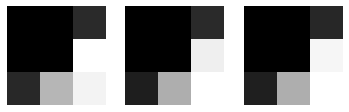


Layer: Block1_Conv1 /n Filter: 22 
 First row shows positive pattern, second negative.


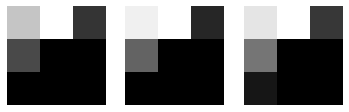

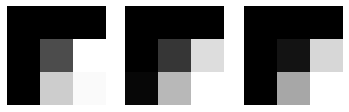


Layer: Block1_Conv1 /n Filter: 47 
 First row shows positive pattern, second negative.


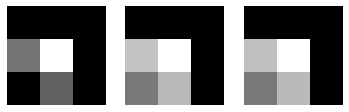

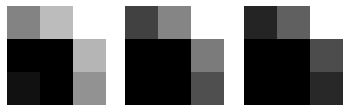

In [251]:
# get and visualize positive and negative weights for some filters in first layer block1_conv1
cl1_f1_pos = kernel_image(first_layer_weights, 0, True)
cl1_f1_neg = kernel_image(first_layer_weights, 0, False)
print('Layer: Block1_Conv1 /n Filter: 1 \n First row shows positive pattern, second negative.')
visualize_patterns([cl1_f1_pos, cl1_f1_neg])

cl1_f15_pos = kernel_image(first_layer_weights, 21, True)
cl1_f15_neg = kernel_image(first_layer_weights, 21, False)
print('\nLayer: Block1_Conv1 /n Filter: 22 \n First row shows positive pattern, second negative.')
visualize_patterns([cl1_f15_pos, cl1_f15_neg])

cl1_f30_pos = kernel_image(first_layer_weights, 46, True)
cl1_f30_neg = kernel_image(first_layer_weights, 46, False)
print('\nLayer: Block1_Conv1 /n Filter: 47 \n First row shows positive pattern, second negative.')
visualize_patterns([cl1_f30_pos, cl1_f30_neg])

### Notes on Part 4: Visualizing learned features 
As illustrated by the above examples, different filters emphasizes different patterns. Light squares correspond to higher values (i.e., larger weights) and dark squares the opposite. As seen in our overview of the model's convolutional layers, all convolutional layers in the VGG-16 model is 3x3, therefore these patterns are represented as 3x3 matrices. Since positive pattern shows enabling features, and negative pattern disabling features, one can see that areas which enables features in the positive pattern (light squares) are represented as small weights for the corresponding negative pattern (dark squares). Sometimes pattern were close to identical over the three channels, like most examples shown here. 